# Dependency parsing of the answers

In [1]:
import stanza
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords

In [2]:
stanza.download('sv', processors='tokenize,pos,lemma,depparse')
nlp = stanza.Pipeline(lang='sv', processors='tokenize,pos,lemma,depparse')

# Example usage
doc = nlp('Du behöver ta med ditt pass.')
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')

2022-02-24 11:57:20 INFO: Downloading these customized packages for language: sv (Swedish)...
| Processor | Package   |
-------------------------
| tokenize  | talbanken |
| pos       | talbanken |
| lemma     | talbanken |
| depparse  | talbanken |
| pretrain  | talbanken |

2022-02-24 11:57:20 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/tokenize/talbanken.pt.
2022-02-24 11:57:20 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/pos/talbanken.pt.
2022-02-24 11:57:20 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/lemma/talbanken.pt.
2022-02-24 11:57:20 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/depparse/talbanken.pt.
2022-02-24 11:57:20 INFO: File exists: /Users/filippakarrfelt/stanza_resources/sv/pretrain/talbanken.pt.
2022-02-24 11:57:20 INFO: Finished downloading models and saved to /Users/filippakarrfelt/stanza_resources.
2022-02-24 11:57:20 INFO: Loading these models for language: sv (Swedish):
| Processor | Package  

id: 1	word: Du	head id: 3	head: ta	deprel: nsubj
id: 2	word: behöver	head id: 3	head: ta	deprel: aux
id: 3	word: ta	head id: 0	head: root	deprel: root
id: 4	word: med	head id: 3	head: ta	deprel: compound:prt
id: 5	word: ditt	head id: 6	head: pass	deprel: nmod:poss
id: 6	word: pass	head id: 3	head: ta	deprel: obj
id: 7	word: .	head id: 3	head: ta	deprel: punct


In [3]:
stop_words = set(stopwords.words('swedish'))
stop_words.add('vad')
stop_words.add('vems')
stop_words.add('varifrån')
stop_words.add('vemvilka')

In [4]:
# Load the dataframe consisting of the data
df_train = pd.read_pickle("./data_frames/df_train.pkl")
df_train_cleaned = pd.read_pickle("./data_frames/df_train_cleaned.pkl")
df_train.head()

,choices,context,question,correct_answer,correct_answer_parsed,correct_answer_parsed_tok,correct_answer_parsed_stop,correct_answer_parsed_lemma,correct_answer_parsed_lemma_stop,correct_answer_loc,...,answer_location,sent_with_ans,answer_locations_text,paragraph_len,loc_frac,context_parsed,context_parsed_tok_lemma,context_parsed_tok_lemma_stop,context_parsed_tok_stop,context_parsed_tok
0,"[{'end': 224, 'extra': None, 'start': 175, 'te...",Visum för affärs- och konferensbesök\r\nOm du ...,Vad är ett visum?,ett tillstånd för att resa in och vara i ett land,ett tillstånd för att resa in och vara i ett land,"[ett, tillstånd, för, att, resa, in, och, vara...","[tillstånd, resa, in, land]","[en, tillstånd, för, att, resa, in, och, vara,...","[tillstånd, resa, in, land]",175,...,2,visum är ett tillstånd för att resa in och var...,[2],21,0.095238,"[visum för affärs- och konferensbesök, om du s...","[[visa, för, affär, och, konferensbesök], [om,...","[[visa, affär, konferensbesök], [om, skola, be...","[[visum, affärs-, konferensbesök], [om, ska, b...","[[visum, för, affärs-, och, konferensbesök], [..."
1,"[{'end': 707, 'extra': None, 'start': 681, 'te...",Eget företag\r\nEfter beslut\r\nBeslutet skick...,Vad ska du ta med när du hämtar ditt beslut?,ditt pass,ditt pass,"[ditt, pass]",[pass],"[du, pass]",[pass],156,...,2,när du ska hämta ditt beslut ska du ta med dit...,"[2, 3]",19,0.105263,"[eget företag, efter beslut beslutet skickas t...","[[egen, företag], [efter, beslut, beslut, skic...","[[egen, företag], [efter, beslut, beslut, skic...","[[eget, företag], [efter, beslut, beslutet, sk...","[[eget, företag], [efter, beslut, beslutet, sk..."
2,"[{'end': 1165, 'extra': None, 'start': 1154, '...",Utbytesdoktorander\r\nIntervju\r\nDu kommer at...,Hur länge gäller ett uppehållstillstånd för be...,ett år,ett år,"[ett, år]",[år],"[en, år]",[år],1619,...,18,så länge gäller tillståndet ett uppehållstills...,[18],25,0.720000,"[utbytesdoktorander intervju, du kommer att få...","[[utbytesdoktorand, intervju], [du, komma, att...","[[utbytesdoktorand, intervju], [du, komma, få,...","[[utbytesdoktorander, intervju], [du, kommer, ...","[[utbytesdoktorander, intervju], [du, kommer, ..."
3,"[{'end': 598, 'extra': None, 'start': 589, 'te...",Eget företag\r\nNär vi har tagit emot din ansö...,Vad är ett uppehållstillståndskort?,ett bevis,ett bevis,"[ett, bevis]",[bevis],"[en, bevis]",[bevis],589,...,8,kortet är ett bevis på att du har tillstånd at...,[8],21,0.380952,"[eget företag, när vi har tagit emot din ansök...","[[egen, företag], [när, vi, ha, ta, emot, du, ...","[[egen, företag], [när, ta, emot, ansökan], [o...","[[eget, företag], [när, tagit, emot, ansökan],...","[[eget, företag], [när, vi, har, tagit, emot, ..."
4,"[{'end': 1932, 'extra': None, 'start': 1924, '...",Flytta tillbaka till Sverige\r\nSå ansöker du\...,Vad är ett uppehållstillståndskort?,ett bevis,ett bevis,"[ett, bevis]",[bevis],"[en, bevis]",[bevis],673,...,8,kortet är ett bevis på att du har tillstånd at...,[8],21,0.380952,"[flytta tillbaka till sverige, så ansöker du d...","[[flytta, tillbaka, till, Sverige], [så, ansök...","[[flytta, tillbaka, Sverige], [så, ansöka, du,...","[[flytta, tillbaka, sverige], [så, ansöker, du...","[[flytta, tillbaka, till, sverige], [så, ansök..."


In [5]:
# Find the word type of the root in every answer in the dataset
def parse_doc(doc):
    dict = { 'lemmas': [], 'stop_lemmas': [], 'words': [], 'stop_words': [], 'pos': [], 'deprel': [], 'root': None, 'root_word': None, 'root_pos': None,}
    for sentence in doc.sentences:
        for word in sentence.words:
            # TODO: remove stopwords
            # print(word.text, word.lemma, word.pos, word.deprel)
            dict['lemmas'].append(word.lemma)
            dict['words'].append(word.text)
            dict['pos'].append(word.pos)
            dict['deprel'].append(word.deprel)
            if not word.text in stop_words:
                dict['stop_lemmas'].append(word.lemma)
                dict['stop_words'].append(word.text)
            if word.deprel == 'root':
                dict['root'] = word.lemma
                dict['root_word'] = word.text
                dict['root_pos'] = word.pos
    return dict

def add_to_dependency_dict(answer, sent_with_ans, question, ans_doc, sent_doc, q_doc):
    ans_dict = parse_doc(ans_doc)
    sent_dict = parse_doc(sent_doc)
    q_dict = parse_doc(q_doc)
    dict_item = { 'answer': answer, 'answer_lemmas': [], 'answer_stop_lemmas': [], 'answer_words': [], 'answer_stop_words': [], 'answer_pos': [], 'answer_deprel': [], 'answer_root': None, 'answer_root_pos': None,
            'sent_with_ans': sent_with_ans, 'sent_lemmas': [],'sent_stop_lemmas': [], 'sent_words': [], 'sent_stop_words': [], 'sent_pos': [], 'sent_deprel': [], 'sent_root': None, 'sent_root_pos': None,
            'question': question, 'q_lemmas': [], 'q_stop_lemmas': [], 'q_words': [], 'q_stop_words': [], 'q_pos': [], 'q_deprel': [], 'q_root': None, 'q_root_pos': None }

    pre_scripts = [('answer_', ans_dict), ('sent_', sent_dict), ('q_', q_dict)]
    for pre in pre_scripts:
        dict_item[pre[0]+'lemmas'] = pre[1]['lemmas']
        dict_item[pre[0]+'stop_lemmas'] = pre[1]['stop_lemmas']
        dict_item[pre[0]+'words'] = pre[1]['words']
        dict_item[pre[0]+'stop_words'] = pre[1]['stop_words']
        dict_item[pre[0]+'pos'] = pre[1]['pos']
        dict_item[pre[0]+'deprel'] = pre[1]['deprel']
        dict_item[pre[0]+'root'] = pre[1]['root']
        dict_item[pre[0]+'root_word'] = pre[1]['root_word']
        dict_item[pre[0]+'root_pos'] = pre[1]['root_pos']
    return dict_item

def dependency_parsing(df):
    dependency_dict = []
    for index, row in df.iterrows():
        answer = row['correct_answer_parsed']
        sent_with_ans = row['sent_with_ans']
        question = row['question_parsed']
        ans_doc = nlp(answer)
        sent_doc = nlp(sent_with_ans)
        q_doc = nlp(question)
        dependency_dict.append(add_to_dependency_dict(answer, sent_with_ans, question, ans_doc, sent_doc, q_doc))
    
    return dependency_dict


In [6]:
# get the word class statistics for the root
def get_word_class_count(data, type):
    stats = {}
    for ans in data:
        word_pos = ans[type + '_root_pos']
        # can be none!
        if word_pos == None:
            print('word has None pos tag: ', ans[type + '_root_word'])
            if 'UNK' not in stats:
                stats['UNK'] = 1
            else:
                stats['UNK'] += 1
        elif word_pos not in stats:
            stats[word_pos] = 1
        else:
            stats[word_pos] += 1
    return stats

In [7]:
# print stats
def print_wordcount_stats(stats, title):
    print('stats: ', stats)
    plt.bar(stats.keys(), stats.values(), color='g')
    plt.title(title)
    plt.show()


In [32]:
dict = dependency_parsing(df_train)
# Save as dataframe
dp_dict_train = pd.DataFrame(dict)
# Save dataframe to file
dp_dict_train.to_pickle("./data_frames/dependency_parsing/df_dp_train.pkl")

In [8]:
dict_cleaned = dependency_parsing(df_train_cleaned)
# Save as dataframe
dp_dict_train_cleaned = pd.DataFrame(dict_cleaned)
# Save dataframe to file
dp_dict_train_cleaned.to_pickle("./data_frames/dependency_parsing/df_dp_train_cleaned.pkl")

stats:  {'NOUN': 506, 'VERB': 346, 'NUM': 63, 'ADJ': 25, 'ADV': 3, 'PRON': 7, 'PROPN': 11, 'ADP': 1}


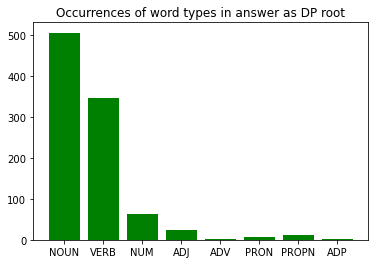

stats:  {'NOUN': 135, 'VERB': 745, 'NUM': 2, 'AUX': 19, 'ADJ': 58, 'PRON': 3}


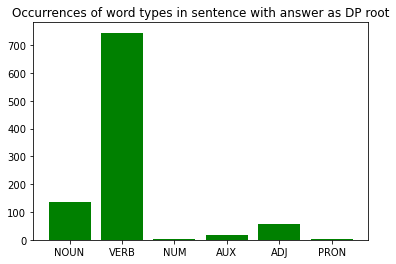

stats:  {'PRON': 73, 'VERB': 767, 'NOUN': 79, 'ADJ': 35, 'ADV': 1, 'AUX': 6, 'NUM': 1}


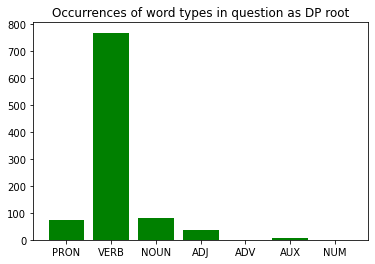

In [34]:
# PLOT STATISTICS

# ans stats
ans_stats = get_word_class_count(dict, 'answer')
title_ans = 'Occurrences of word types in answer as DP root'
print_wordcount_stats(ans_stats, title_ans)

# ans sent stats
sent_stats = get_word_class_count(dict, 'sent')
title_ans = 'Occurrences of word types in sentence with answer as DP root'
print_wordcount_stats(sent_stats, title_ans)

# question stats
q_stats = get_word_class_count(dict, 'q')
title_ans = 'Occurrences of word types in question as DP root'
print_wordcount_stats(q_stats, title_ans)
